In [1]:
import torch
import torchvision
from torchvision import transforms

import pytorch_lightning as pl

from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchmetrics

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import seaborn as sn
import pandas as pd


In [2]:
##########################
### Configurações
##########################

### MODEL_NAME = MODELO + IMAGENS + DETALHES
MODEL_NAME = "ResNet50"

# Hyperparameters
LEARNING_RATE = 1e-6
BATCH_SIZE = 8 if torch.cuda.is_available() else 64
NUM_WORKERS = 0 # Zero for Windows
NUM_EPOCHS = 3

# Architecture
NUM_CLASSES = 7

# Other
DEVICE = "cuda:0" # ou "CPU"

width_pic = 224
height_pic = 224



In [3]:
PATH_DS_PROCESSED_TEST = Path("./IMG224_ALL/PROCESSED-TEST")

pathname = "./WEIGHTS/" + MODEL_NAME + "/"
PATH_DS_WEIGHTS = Path(pathname)


In [4]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [5]:
mean = torch.tensor([118.9568,  76.7986,  43.6991]) 
stq = torch.tensor([71.9256, 50.9931, 35.3619])     

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,stq),
])


In [6]:
#Datasets
TEST_DATASET = torchvision.datasets.DatasetFolder(
    PATH_DS_PROCESSED_TEST,
    loader=load_file, extensions="npy", transform=test_transforms)



In [7]:
TEST_LOADER = torch.utils.data.DataLoader(TEST_DATASET, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

In [8]:
class LTResNet50Module(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.learning_rate = LEARNING_RATE      
        
        self.model = torchvision.models.resnet50(pretrained=True)
        
        fc_in_features = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(in_features=fc_in_features, out_features=NUM_CLASSES, bias=True)
        
        self.loss_fn = torch.nn.CrossEntropyLoss()

        self.metric_train_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=NUM_CLASSES)
        self.metric_val_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=NUM_CLASSES)   
        self.metric_test_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=NUM_CLASSES)
        
        self.metric_train_f1score = torchmetrics.classification.MulticlassF1Score(num_classes=NUM_CLASSES)
        self.metric_val_f1score = torchmetrics.classification.MulticlassF1Score(num_classes=NUM_CLASSES)    
        self.metric_test_f1score = torchmetrics.classification.MulticlassF1Score(num_classes=NUM_CLASSES)

    def forward(self, x):
        x = self.model(x)
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        #optimizer = torch.optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,3,5,7,8,10,15,20], gamma=0.5)

        return [optimizer], [scheduler]
        
    def training_step(self, batch, batch_idx):
        x, labels = batch
        preds = self.model(x)

        loss = self.loss_fn(preds, labels)
        
        pred_labels = torch.argmax(preds, dim=1)
        
        self.metric_train_accuracy.update(pred_labels, labels)
        self.metric_train_f1score.update(pred_labels, labels)
        
        self.log("train_st_loss", loss)
        
        return loss
    
    def training_epoch_end(self, outs):
        self.log("train_epoch_acc", self.metric_train_accuracy.compute())
        self.log("train_epoch_f1score", self.metric_train_f1score.compute())
        self.metric_train_accuracy.reset()
        self.metric_train_f1score.reset()

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        preds = self.model(x)
        loss = self.loss_fn(preds, labels)
        pred_labels = torch.argmax(preds, dim=1)
        
        self.metric_val_accuracy.update(pred_labels, labels)
        self.metric_val_f1score.update(pred_labels, labels)
        
        self.log("val_st_loss", loss)
        
    def validation_epoch_end(self, outs):
        self.log("val_epoch_acc", self.metric_val_accuracy.compute(), prog_bar=True)
        self.log("val_epoch_f1score", self.metric_val_f1score.compute())
        self.metric_val_accuracy.reset()
        self.metric_val_f1score.reset()

    def test_step(self, batch, batch_idx):
        x, labels = batch
        preds = self.model(x).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        self.log("test_acc", acc)

        

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LTResNet50Module.load_from_checkpoint(PATH_DS_WEIGHTS / "epoch=2-step=1914.ckpt") # buscar o arquivo com os pesos no pasta WEIGHTS
model.eval()
model.to(device);


C:\Users\AsusTon\anaconda3\envs\tcc_evn\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\AsusTon\anaconda3\envs\tcc_evn\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:

preds = []
predsROC = []
labels = []
names = []
i = 0

with torch.no_grad():
    for data, label in tqdm(TEST_DATASET):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        predsROC.append(pred.numpy())
        pred2 = pred.argmax(dim=-1)
        preds.append(pred2)
        labels.append(label)
        names.append(TEST_DATASET.samples[i][0].split("\\")[2])
        
        i+=1

preds = torch.tensor(preds)
labels = torch.tensor(labels).int()


  0%|          | 0/1386 [00:00<?, ?it/s]

In [12]:
#        0-N - Normal
#        1-D - Diabetes
#        2-G - Glaucoma
#        3-C - Catarata
#        4-A - Degeneração macular
#        5-H - Hipertensao
#        6-M - Miopia patológica  

acc = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES)(preds, labels)
precision = torchmetrics.Precision(task='multiclass', num_classes=NUM_CLASSES)(preds, labels)
recall = torchmetrics.Recall(task='multiclass', num_classes=NUM_CLASSES)(preds, labels)
F1Score = torchmetrics.F1Score(task='multiclass', num_classes=NUM_CLASSES)(preds, labels)

cm = torchmetrics.ConfusionMatrix(task='multiclass',num_classes=NUM_CLASSES)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Val F1Score: {F1Score }")
print(f"Confusion Matrix:\n {cm}")



Val Accuracy: 0.6601731777191162
Val Precision: 0.6601731777191162
Val Recall: 0.6601731777191162
Val F1Score: 0.6601731777191162
Confusion Matrix:
 tensor([[789,   5,   0,  20,   0,   0,   5],
        [262,  10,   0,   2,   0,   0,   2],
        [ 61,   1,   0,   3,   0,   0,   0],
        [  4,   0,   0,  77,   0,   0,   0],
        [ 69,   0,   0,   1,   0,   0,   0],
        [ 26,   1,   0,   0,   0,   0,   0],
        [  6,   0,   0,   3,   0,   0,  39]])


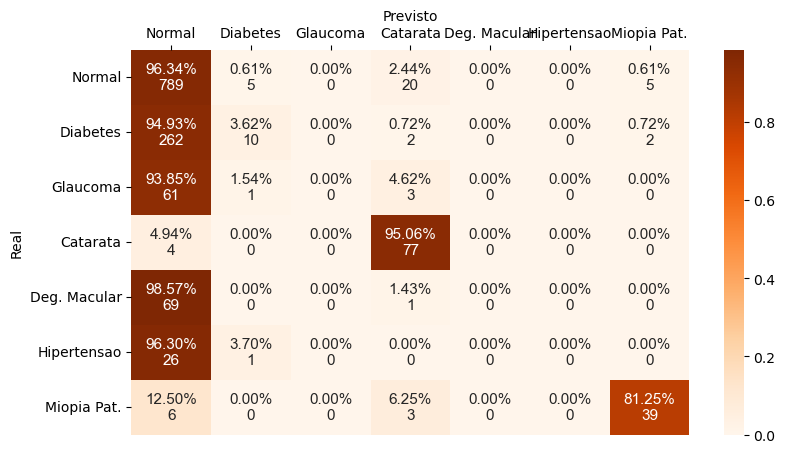

In [14]:
# Matriz de Confusão

classes = ["Normal","Diabetes","Glaucoma", "Catarata", "Deg. Macular","Hipertensao", "Miopia Pat."]
cm_npy = cm.numpy()
cm_percent = cm_npy / np.sum(cm_npy, axis=1)[:, None]

group_counts = ["{0:0.0f}".format(value) for value in cm_npy.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_percent.flatten()]
cm_labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_percentages, group_counts)]
cm_labels  = np.asarray(cm_labels).reshape(NUM_CLASSES, NUM_CLASSES)


data_frame_cm = pd.DataFrame(cm_percent , index=[i for i in classes],
                         columns=[i for i in classes])



plt.figure(figsize=(9, 5))    

ax = sn.heatmap(data_frame_cm, annot=cm_labels,annot_kws={"size": 11, "family":"Arial"}, fmt='', cmap='Oranges')
ax.set(xlabel="Previsto", ylabel="Real")
ax.xaxis.set_label_position('top')


ax.tick_params(axis='x', labelsize=10, bottom= False, top= True, left=False, right= False, labelbottom = False, labeltop=True)
ax.tick_params(axis='y', labelsize=10, bottom= False, top= False, left=True, right= False, labelbottom = False, labeltop=False)


In [15]:
F1Score2 = torchmetrics.F1Score(task='multiclass', num_classes=NUM_CLASSES)(preds, labels)
F1Score2_macro = torchmetrics.F1Score(task='multiclass', num_classes=NUM_CLASSES, average='macro')(preds, labels)

print(F1Score2)
print(F1Score2_macro)

Accuracy2 = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES)(preds, labels)
Accuracy2_macro = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES, average='macro')(preds, labels)

print(Accuracy2)
print(Accuracy2_macro)

tensor(0.6602)
tensor(0.3567)
tensor(0.6602)
tensor(0.3947)


In [16]:
acc = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES, average=None)(preds, labels)
precision = torchmetrics.Precision(task='multiclass', num_classes=NUM_CLASSES, average=None)(preds, labels)
recall = torchmetrics.Recall(task='multiclass', num_classes=NUM_CLASSES, average=None)(preds, labels)
F1Score = torchmetrics.F1Score(task='multiclass', num_classes=NUM_CLASSES, average=None)(preds, labels)


print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Val F1Score: {F1Score }")

Val Accuracy: tensor([0.9634, 0.0362, 0.0000, 0.9506, 0.0000, 0.0000, 0.8125])
Val Precision: tensor([0.6483, 0.5882, 0.0000, 0.7264, 0.0000, 0.0000, 0.8478])
Val Recall: tensor([0.9634, 0.0362, 0.0000, 0.9506, 0.0000, 0.0000, 0.8125])
Val F1Score: tensor([0.7750, 0.0683, 0.0000, 0.8235, 0.0000, 0.0000, 0.8298])


In [19]:
def GetDescription(label):
    classes  = ["Normal","Diabetes","Glaucoma", "Catarata", "Deg. Macular","Hipertensao", "Miopia Pat."]
    int_label = int(label)
    return classes[int_label]
    
    
predsROC =  torch.tensor(predsROC)

rocMetric = torchmetrics.classification.MulticlassROC(num_classes=NUM_CLASSES, thresholds=None)
fpr, tpr, thresholds = rocMetric(predsROC, labels)

aurocMetric = torchmetrics.classification.MulticlassAUROC(num_classes=NUM_CLASSES, thresholds=None)
auroc = aurocMetric(predsROC, labels)


aurocClassesMetric = torchmetrics.classification.MulticlassAUROC(num_classes=NUM_CLASSES, thresholds=None, average= None)
aurocClasses = aurocClassesMetric(predsROC, labels)



C:\Users\AsusTon\AppData\Local\Temp\ipykernel_10792\948968265.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predsROC =  torch.tensor(predsROC)


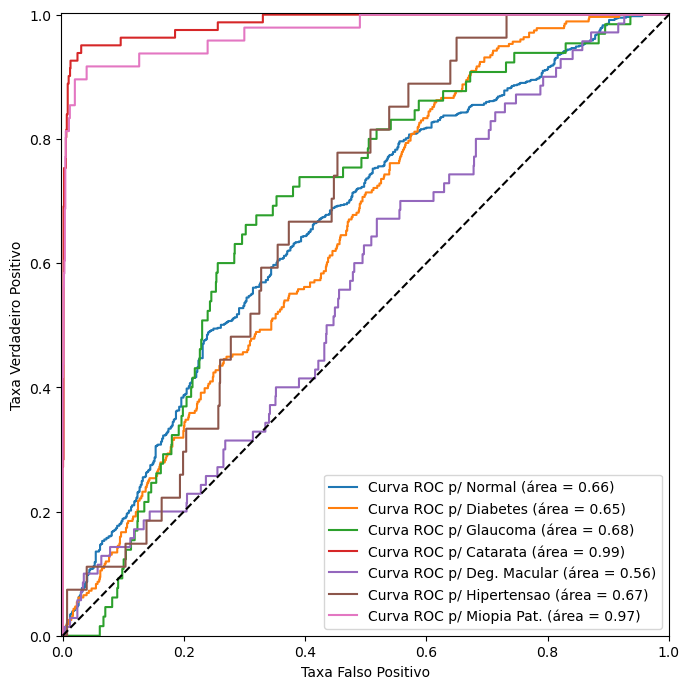

In [20]:


plt.figure(figsize=(7,7))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label='Curva ROC p/ {0} (área = {1:0.2f})'
                                   ''.format(GetDescription(i), aurocClasses[i]))  # roc_auc_score

plt.plot([0, 1], [0, 1], 'k--')
# plt.grid()
plt.xlim([-0.002, 1.0])
plt.ylim([0.0, 1.002])
plt.xlabel('Taxa Falso Positivo')
plt.ylabel('Taxa Verdadeiro Positivo')
#plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()